<a href="https://colab.research.google.com/github/Alephant6/nlp-kaggle/blob/main/d2l/14_4_%E9%A2%84%E8%AE%AD%E7%BB%83word2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l
!pip install matplotlib==3.0.0

In [2]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

## 1 跳元模型

In [4]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight({embed.weight.shape},'
  f'dtype={embed.weight.dtype})')

Parameter embedding_weight(torch.Size([20, 4]),dtype=torch.float32)


In [5]:
x = torch.tensor([[1,2,3], [4,5,6]])
embed(x)

tensor([[[ 0.1401,  0.3095, -1.9684,  0.9099],
         [-1.2213, -1.5276, -1.0143, -1.3292],
         [ 1.4141,  0.4778, -1.0600, -0.2067]],

        [[-0.4592,  0.6447, -0.9211, -1.1902],
         [-1.8258, -1.0360, -0.6414,  0.7381],
         [ 1.5724, -0.0142,  0.0871,  0.0771]]], grad_fn=<EmbeddingBackward0>)

In [6]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
  v = embed_v(center)
  u = embed_u(contexts_and_negatives)
  pred = torch.bmm(v, u.permute(0, 2, 1))
  return pred

skip_gram(torch.ones((2,1), dtype=torch.long),
      torch.ones((2,4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## 2 训练

In [7]:
class SigmoidBCELoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, inputs, target, mask=None):
    out = nn.functional.binary_cross_entropy_with_logits(
        inputs, target, weight=mask, reduction='none'
    )
    return out.mean(dim=1)

loss = SigmoidBCELoss()

In [8]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [9]:
def sigmd(x):
  return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


In [10]:
embed_size = 100
net = nn.Sequential(nn.Embedding(num_embeddings=len(vocab),
                embedding_dim=embed_size),
            nn.Embedding(num_embeddings=len(vocab),
                embedding_dim=embed_size))

In [11]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
  def init_weights(m):
    if type(m) == nn.Embedding:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr)
  animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                xlim=[1, num_epochs])
  metric = d2l.Accumulator(2)
  for epoch in range(num_epochs):
    timer, num_batches = d2l.Timer(), len(data_iter)
    for i, batch in enumerate(data_iter):
      optimizer.zero_grad()
      center, context_negative, mask, label = [
        data.to(device) for data in batch
      ]

      pred = skip_gram(center, context_negative, net[0], net[1])
      l = (loss(pred.reshape(label.shape).float(), label.float(),mask)
        / mask.sum(axis=1) * mask.shape[1])
      l.sum().backward()
      optimizer.step()
      metric.add(l.sum(), l.numel())
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches,
                (metric[0] / metric[1],))
  print(f'loss{metric[0] / metric[1]:.3f}, '
      f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

loss0.410, 356119.1 tokens/sec on cuda:0


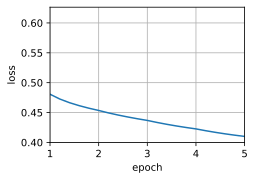

In [12]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 对比CPU和GPU
GPU几乎是CPU的6倍
### CPU
![](https://cdn.jsdelivr.net/gh/Alephant6/PicBed/202206102156430.png)

### GPU
![](https://cdn.jsdelivr.net/gh/Alephant6/PicBed/202206102159157.png)